### Постановка задачи
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Шаг 1. Загрузка библиотек и массивов статистических данных

In [1]:
# загрузка необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, classification_report
from datetime import datetime
import lightgbm as lgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# изменение стиля построения диаграмм
plt.style.use('ggplot')
# зафиксируем генератор псевдослучайных чисел 
RandomState = 42

In [4]:
# загрузка данных:
# по довогору
contract = pd.read_csv('contract.csv')
# по персональных данных клиентов
personal = pd.read_csv('personal.csv')
# по интернет-услугам
internet = pd.read_csv('internet_final.csv')
# по услугам телефонии
phone = pd.read_csv('phone.csv')

### Шаг 2. Подготовка данных к моделированию

In [5]:
# Объединим отдельные массивы в единую выборочную совокупность по идентификационному номеру пользователей
# при этом используем внешнее объединение.
X = (
    # массив по договорам соединяем с информацией по :
    contract\
    # (1) персональным данным
    .merge(personal, on=['customerID'], how='outer')\
    # (2) интернет-услугам
    .merge(internet, on=['customerID'], how='outer')\
    # (3) услугам телефонии
    .merge(phone, on=['customerID'], how='outer')
)

In [6]:
# вывод общей информации по выборочной совокупности
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [7]:
# Определим количество пропущенных наблюдений 
X.isnull().sum().sort_values(ascending=False)

StreamingTV         1526
TechSupport         1526
DeviceProtection    1526
OnlineBackup        1526
OnlineSecurity      1526
InternetService     1526
StreamingMovies     1526
MultipleLines        682
PaymentMethod          0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
SeniorCitizen          0
MonthlyCharges         0
TotalCharges           0
gender                 0
Partner                0
Dependents             0
customerID             0
dtype: int64

In [8]:
# Вычислим количество дублирующих наблюдений
X.duplicated().sum()

0

In [9]:
# Заполним пропущенные наблюдения меткой 'No'
X = X.fillna(value='No')

In [10]:
# Через цикл for
for row in range(len(X)):
    # наблюдения у которых есть пробелы в столбце TotalCharges 
    if X.loc[row,'TotalCharges'] == ' ':
        # заменим на метку отсутствия информации, т.е. NaN
        X.loc[row,'TotalCharges'] = np.NaN

In [11]:
# Две корректировки в переменной TotalCharges:
# (1) заполнение пропущенных наблюдений медианным значением
# (2) преобразование со строкового формата в формат с плавающей точкой
X['TotalCharges'] = (
    X['TotalCharges']\
    .fillna(value=X['TotalCharges'].median()).astype(float)  
)

In [12]:
# Создадим столбец is_active_customer, где единичное значение обозначает действующего пользователя, 
# нулевое значение - это недействующий пользователь
X['is_active_customer'] = X['EndDate'].apply(lambda x: 1 if x=='No' else 0)

In [13]:
# Создадим столбец даты начала заключения договора begin_date в формате datetime
X['begin_date'] = pd.to_datetime(X['BeginDate'])
# Создадим столбец даты завершения действия довогора end_date.
# Заполним наблюдения где отсутствует дата завершения договора на 1 февраля 2020 года (исходя из условия задания)
X['end_date'] = X['EndDate'].apply(lambda x: datetime(2020,3,1) if x=='No' else x)

In [14]:
# Создадим столбец duration, который отражает продолжительность срока действия договора в днях
X['duration'] = (
    pd.to_timedelta(X['end_date'] - X['begin_date'])\
    .dt\
    .days # выделяем количество дней
)

In [15]:
def plot_customers_by_feature(feature):
    # Создадим фигура для построения диаграммы
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    # Построим плотностную гистограмму продолжительности срока действия договора для действующих пользователей
    X.loc[X['is_active_customer']==1,feature].plot(ax=ax, kind='hist', density=True, histtype='step',
                                                  color='green', label='active', lw=5)
    # Построим плотностную гистограмму продолжительности срока действия договора для недействующих пользователей
    X.loc[X['is_active_customer']==0, feature].plot(ax=ax, kind='hist', density=True, histtype='step',
                                                   color='red', label='inactive', lw=5)
    # Вывод легенды
    plt.legend()

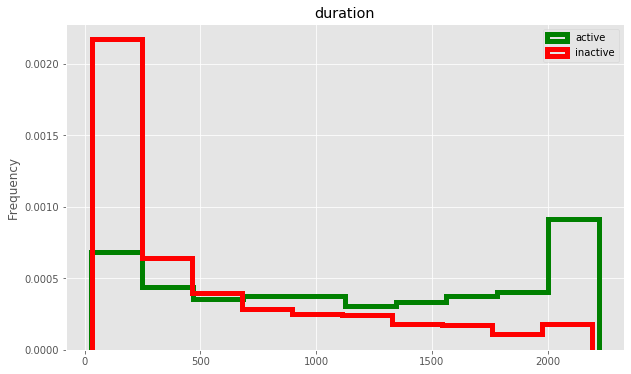

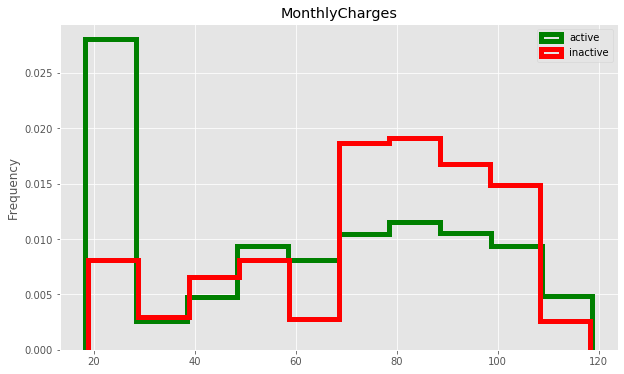

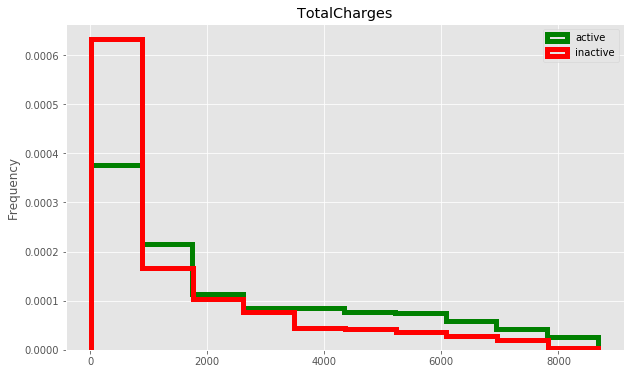

In [16]:
# В разрезе классов целевого признака построим плотностные гистограммы по трем переменным
# (1) продолжительность срока договора, (2) ежемесячные и (3) совокупные выплаты
for feature in ['duration','MonthlyCharges','TotalCharges']:
    plot_customers_by_feature(feature)
    # обозначение заголовка диаграммы
    plt.title(feature)
    # отображение диаграммы
    plt.show()

- большая часть уже недействующих пользователей были клиентами менее 250 дней. То есть, более частый срок "жизни" недействующих клиентов равен менее 250-ти дням).
- наблюдается большая доля индивидов, которые являются действующими клиентами уже более 2000 дней (от начала подписания договора до 1 февраля 2020 года).
- действующие пользователи зачастую имеют ежемесячные выплаты от 20 до 30 у.е.
- недействующие пользователи зачастую имеют ежемесячные выплаты от 70 до 110 у.е.
- по совокупным выплатам действующие и недействующие пользователи весьма схожи кроме того, что по недействующим пользователям более вероятны выплаты менее 1000 у.е.

In [17]:
# Создадим массив X_reduced через удаление неинформативных переменных из исходной выборочной совокупности
X_reduced = X.drop(labels=['customerID','BeginDate','EndDate',
                           'begin_date','end_date','is_active_customer'], axis=1)

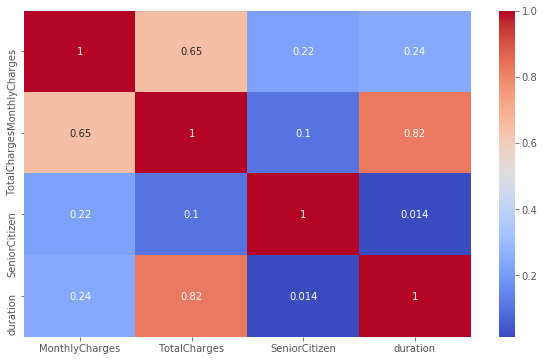

In [18]:
# Построим тепловую диаграмму корреляционной матрицы выборочной совокупности
plt.figure(figsize=(10,6))
sns.heatmap(X_reduced.corr(), annot=True, cmap='coolwarm')

In [19]:
# Создадим массив характеристик с конвертацией некоторых переменных в индикаторный формат (0 либо 1)
features = pd.get_dummies(X_reduced, drop_first=True)

In [20]:
# Удалим лишний массив данных
del X_reduced

In [21]:
# Вывод итогового массива характеристик
features.head()

,MonthlyCharges,TotalCharges,SeniorCitizen,duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,29.85,29.85,0,60,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,56.95,1889.50,0,1065,1,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
2,53.85,108.15,0,61,0,0,1,0,0,1,...,0,0,0,1,1,0,0,0,0,0
3,42.30,1840.75,0,1400,1,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
4,70.70,151.65,0,61,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [22]:
# Вывод общей информации по массиву характеристик
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7043 non-null   float64
 1   TotalCharges                           7043 non-null   float64
 2   SeniorCitizen                          7043 non-null   int64  
 3   duration                               7043 non-null   int64  
 4   Type_One year                          7043 non-null   uint8  
 5   Type_Two year                          7043 non-null   uint8  
 6   PaperlessBilling_Yes                   7043 non-null   uint8  
 7   PaymentMethod_Credit card (automatic)  7043 non-null   uint8  
 8   PaymentMethod_Electronic check         7043 non-null   uint8  
 9   PaymentMethod_Mailed check             7043 non-null   uint8  
 10  gender_Male                            7043 non-null   uint8  
 11  Part

Матрица характеристик содержит 22 переменные.

In [23]:
# Определение вектора целевого признака
target = X['is_active_customer']

### Шаг 3. Обучение моделей

In [24]:
# Подсчет количества классов в векторе целевого признака
target.value_counts(normalize=True)

1    0.73463
0    0.26537
Name: is_active_customer, dtype: float64

Имеем несбалансированность классов целевого признака почти втрое. Для решения данной проблемы увеличим долю наблюдений недостающего класса целевого признака.

In [25]:
# Определим функцию upsample, которая увеличивает выборку с наименьшим количеством величин целевого признака.
# В частности увеличивается выборка недействующих пользователей.
def upsample(features, target, repeat):
    '''
    features: массив данных, содержащий характеристики клиентов
    target: массив данных целевого признака
    repeat: количество раз увеличения выборки с наименьшим количеством величин целевого признака
    ------
    output: (1) features_upsampled: увеличенная выборка, (2) target_upsampled: увеличенный вектор целевого признака
    '''
    # Массив характеристик, у которых целевой признак является нулевым
    features_zeros = features[target == 0]
    # Массив характеристик, у которых целевой признак равен единице
    features_ones = features[target == 1]
    # Вектор значений с нулевым целевым признаком
    target_zeros = target[target == 0]
    # Вектор значений с единичным целевым признаком
    target_ones = target[target == 1]
    # Соединяем (1) исходную выборку с преобладающим числом целевого признака, 
    # (2) увеличенной выборкой с наименьшим числом целевого признака
    # в контексте массива характеристик
    features_upsampled = pd.concat([features_ones] + [features_zeros]*repeat)
    # в контексте вектора целевого признака
    target_upsampled = pd.concat([target_ones] + [target_zeros] * repeat)
    # Перемешиваем наблюдения
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=RandomState)
    # Возвращаем результирующие массивы данных
    return features_upsampled, target_upsampled

In [26]:
# Разделение исходного массива характеристик и вектора целевого признака на обучающее и тестовое множества
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RandomState)

In [27]:
# Создание расширенного массива характеристик и вектора целевого признака
X_upsample, y_upsample = upsample(X_train, y_train, repeat=3)

In [28]:
# Вычислим количества классов в векторе целевого признака
y_upsample.value_counts(normalize=True)

0    0.517241
1    0.482759
Name: is_active_customer, dtype: float64

Получили приблизительно одинаковое процентное соотношение двух классов в векторе целевого признака

Следующий способ балансирования: сокращение доли преобладающего класса в векторе целевого признака.

In [29]:
# Определим функцию downsample, которая
# случайным образом отбирает указанную долю выборки с преобладающим количеством величин целевого признака.
# В частности, сокращаем выборку индивидов, которые еще являются действующими пользователями.
def downsample(features, target, fraction):
    '''
    features: массив данных, содержащий характеристики клиентов
    target: массив данных целевого признака
    fraction: доля выборки с преобладающим количеством величин целевого признака
    ------
    output: (1) features_downsampled: усеченная выборка, (2) target_downsampled: усеченный вектор целевого признака
    '''
    # Массив характеристик, у которых целевой признак является нулевым
    features_zeros = features[target == 0]
    # Массив характеристик, у которых целевой признак равен единице
    features_ones = features[target == 1]
    # Вектор значений с нулевым целевым признаком
    target_zeros = target[target == 0]
    # Вектор значений с единичным целевым признаком
    target_ones = target[target == 1]
    # Соединение (1) усеченной выборки с преобладающим количеством целевого признака,
    # (2) исходной выборкой с меньшим количеством целевого признака
    # для массива с характеристиками клиентов
    features_downsampled = pd.concat(
        [features_ones.sample(frac=fraction, random_state=0)] + [features_zeros])
    # для вектора целевого признака
    target_downsampled = pd.concat(
    [target_ones.sample(frac=fraction, random_state=0)] + [target_zeros])
    # Перемешиваем массив характеристик и вектор целевого признака
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, 
                                                       random_state=RandomState)
    
    return features_downsampled, target_downsampled

In [30]:
# Создание сокращенного массива характеристик и вектора целевого признака
X_downsample, y_downsample = downsample(X_train, y_train, fraction=0.35)

In [31]:
# Подсчет количества классов в векторе целевого признака
y_downsample.value_counts(normalize=True)

0    0.505087
1    0.494913
Name: is_active_customer, dtype: float64

### Промежуточные итоги
- объединили отдельные массивы в единую выборочную совокупность
- создали новую переменную продолжительности срока действия договора `duration` (в днях)
- преобразовали переменные об интернет-услугах, услугах телефонии и персональных данных в индикаторный формат (0 либо 1)
- создали два столбца, которые отображают отсутсвие информации по (1) интернет-услугам и (2) услугам телефонии
- итоговый массив характеристик содержит 24 переменных
- способы балансирования целевого признака: (1) `upsample`: в три раза увеличили долю наименьшего класса в векторе целевого признака: долю недействующих пользователей, (2) `downsample`: отобрали 35 процентов преобладающего класса в векторе целевого признака.

### Шаг 4. Обучение моделей

Обучим 3 модели (1) с учетом аргумента `class_weight='balanced'`, (2) на сокращенной, (3) на расширенной выборках:
- модель случайного леса
- `LightGBM`
- модель логистической регрессии

В итоге, получим 9 моделей.

In [32]:
# Определение диапазона гиперпараметров для модели случайного леса
params_rf = {'n_estimators': np.arange(110,300,10),
             'max_depth': np.arange(10,40,10)}

In [33]:
# Определение диапазона гиперпараметров для модели LightGBM
params_lgbm = {'learning_rate':[0.01,0.05, 0.1],
              'n_estimators':np.arange(110, 200, 10)}

In [34]:
# Определение диапазона гиперпараметров для модели логистической регрессии
params_logreg = {'C':np.arange(1,10), 
                 'penalty':['l1','l2']}

In [35]:
# Зададим словарь оценочных метрик в сетке обучения моделей
grid_scoring = {'ROC_AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score)}

In [36]:
# Определим функцию, которая создает таблицу с двумя результирующими метриками:
# (1) среднее значение точности по кросс-валидации, (2) среднее значение метрики ROC-AUC по кросс-валидации
def mean_cv_results(grid_dict, features_train, features_test, target_train, target_test):
    '''
    grid_dict - словарь сеток моделей
    features_train - обучающее множество 
    features_test - тестовое множество
    target_train - вектор целевого признака из тренировочного множества
    target_test - вектор целевого признака из тестового множества
    
    Результирующая таблица содержит (1) наименование моделей, (2) результирующие метрики
    
    '''
    # Инициализация пустых листов
    roc_auc_list, accuracy_list, mean_cv_accuracy_list, mean_cv_roc_auc_list, model_name_list = [], [], [], [], []
    # Через цилк for для сеток с обученными моделями
    for grid_name, grid_model in grid_dict.items():
        # Вывод среднего значения точности моделей по кросс-валидации
        mean_cv_accuracy = round(pd.DataFrame(grid_model.cv_results_['mean_test_Accuracy']).mean()[0],3)
        # Вывод среднего значения метрики ROC-AUC по кросс-валидации
        mean_cv_roc_auc = round(pd.DataFrame(grid_model.cv_results_['mean_test_ROC_AUC']).mean()[0],3)
        # Включение величины очередной метрики в соответствующий пустой лист
        mean_cv_accuracy_list.append(mean_cv_accuracy)
        mean_cv_roc_auc_list.append(mean_cv_roc_auc)
        # Включение наименования модели
        model_name_list.append(grid_name)
    
    # Создадим таблицу с наименованиями моделей и соответствующими метриками
    metrics_dataframe = pd.DataFrame({'mean_cv_accuracy': mean_cv_accuracy_list,
                                      'mean_cv_roc_auc': mean_cv_roc_auc_list,
                                      'model_name': model_name_list})
    # Возращает итоговую таблицу
    return metrics_dataframe

#### С учетом аргумента `class_weight='balanced'`

Аргумент `class_weight='balanced'` позволяет автоматически корректировать веса обратно пропорционально частоте класса целевого признака согласно формуле `количество_наблюдений / (количество_классов * np.bincount(целевой_признак))`.

In [37]:
# Инициализация модели случайного леса
rf_balance = RandomForestClassifier(random_state=RandomState, class_weight='balanced', n_jobs=-1)

In [38]:
# Определение сетки моделей случайного леса
# Так как ввели две оценочных метрики, то укажем refit='ROC_AUC', чтобы переоценить модель на всей выборке
# с настройками гиперпараметров, которые имеют наибольшее значение метрики ROC-AUC на кросс-валидации
grid_rf_balance = GridSearchCV(estimator=rf_balance, param_grid=params_rf, cv=5, n_jobs=-1, 
                               scoring=grid_scoring, refit='ROC_AUC')

In [39]:
# Обучение моделей случайного леса
grid_rf_balance.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([10, 20, 30]),
                         'n_estimators': array([110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230,
       240, 250, 260, 270, 280, 290])},
             refit='ROC_AUC',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'ROC_AUC': make_scorer(roc_auc_score)})

In [40]:
# Инициализация модели LightGBM
lgbm_balance = lgb.LGBMClassifier(random_state=RandomState, class_weight='balanced', n_jobs=-1)

In [41]:
# Определение сетки моделей LightGBM
grid_lgbm_balance = GridSearchCV(estimator=lgbm_balance, param_grid=params_lgbm, cv=5, n_jobs=-1,
                                scoring=grid_scoring, refit='ROC_AUC')

In [42]:
# Обучение моделей LightGBM
grid_lgbm_balance.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': array([110, 120, 130, 140, 150, 160, 170, 180, 190])},
             refit='ROC_AUC',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'ROC_AUC': make_scorer(roc_auc_score)})

In [43]:
# Инициализация модели логистической регрессии
logreg_balance = LogisticRegression(random_state=RandomState, class_weight='balanced', n_jobs=-1)

In [44]:
# Определение сетки моделей логистической регрессии
grid_logreg_balance = GridSearchCV(estimator=logreg_balance, param_grid=params_logreg, cv=5, n_jobs=-1,
                                   scoring=grid_scoring, refit='ROC_AUC')

In [45]:
# Обучение моделей логистической регрессии
grid_logreg_balance.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', n_jobs=-1,
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'penalty': ['l1', 'l2']},
             refit='ROC_AUC',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'ROC_AUC': make_scorer(roc_auc_score)})

In [46]:
# Определим словарь моделей, обученных с учетом аргумента class_weight='balanced'
grid_dict_balance = {'rf_balance':grid_rf_balance,
                     'lgbm_balance': grid_lgbm_balance,
                     'logreg_balance': grid_logreg_balance}

In [47]:
# Определим таблицу результирующих метрик
mean_cv_balance = mean_cv_results(grid_dict=grid_dict_balance,
                                  features_train=X_train, features_test=X_test,
                                  target_train=y_train, target_test=y_test)

#### Сокращенная выборка

In [48]:
# Инициализация модели случайного леса
rf_downsample = RandomForestClassifier(random_state=RandomState, n_jobs=-1)

In [49]:
# Определение сетки моделей случайного леса
grid_rf_downsample = GridSearchCV(estimator=rf_downsample, param_grid=params_rf, cv=5, n_jobs=-1,
                                  scoring=grid_scoring, refit='ROC_AUC')

In [50]:
# Обучение моделей случайного леса
grid_rf_downsample.fit(X_downsample, y_downsample)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([10, 20, 30]),
                         'n_estimators': array([110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230,
       240, 250, 260, 270, 280, 290])},
             refit='ROC_AUC',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'ROC_AUC': make_scorer(roc_auc_score)})

In [51]:
# Инициализация модели LightGBM
lgbm_downsample = lgb.LGBMClassifier(random_state=RandomState, n_jobs=-1)

In [52]:
# Определение сетки моделей LightGBM
grid_lgbm_downsample = GridSearchCV(estimator=lgbm_downsample, param_grid=params_lgbm, cv=5, n_jobs=-1,
                                    scoring=grid_scoring, refit='ROC_AUC')

In [53]:
# Обучение моделей LightGBM
grid_lgbm_downsample.fit(X_downsample, y_downsample)

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': array([110, 120, 130, 140, 150, 160, 170, 180, 190])},
             refit='ROC_AUC',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'ROC_AUC': make_scorer(roc_auc_score)})

In [54]:
# Инициализация модели логистической регрессии
logreg_downsample = LogisticRegression(random_state=RandomState, n_jobs=-1)

In [55]:
# Определение сетки моделей логистической регрессии
grid_logreg_downsample = GridSearchCV(estimator=logreg_downsample, param_grid=params_logreg, cv=5, n_jobs=-1,
                                      scoring=grid_scoring, refit='ROC_AUC')

In [56]:
# Обучение моделей логистической регрессии
grid_logreg_downsample.fit(X_downsample, y_downsample)

GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'penalty': ['l1', 'l2']},
             refit='ROC_AUC',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'ROC_AUC': make_scorer(roc_auc_score)})

In [57]:
# Сформируем словарь моделей, обученных на сокращенной выборке
grid_dict_downsample = {'rf_downsample': grid_rf_downsample,
                        'lgbm_downsample': grid_lgbm_downsample,
                        'logreg_downsample': grid_logreg_downsample}

In [58]:
# Определим таблицу результирующих метрик
mean_cv_downsample = mean_cv_results(grid_dict=grid_dict_downsample, 
                                     features_train=X_downsample, features_test=X_test,
                                     target_train=y_downsample, target_test=y_test)

#### Расширенная выборка

In [59]:
# Инициализация модели случайного леса
rf_upsample = RandomForestClassifier(random_state=RandomState, n_jobs=-1)

In [60]:
# Определение сетки моделей случайного леса
grid_rf_upsample = GridSearchCV(estimator=rf_upsample, param_grid=params_rf, cv=5, n_jobs=-1,
                                scoring=grid_scoring, refit='ROC_AUC')

In [61]:
# Обучение моделей случайного леса
grid_rf_upsample.fit(X_upsample, y_upsample)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([10, 20, 30]),
                         'n_estimators': array([110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230,
       240, 250, 260, 270, 280, 290])},
             refit='ROC_AUC',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'ROC_AUC': make_scorer(roc_auc_score)})

In [62]:
# Инициализация модели LightGBM
lgbm_upsample = lgb.LGBMClassifier(random_state=RandomState, n_jobs=-1)

In [63]:
# Определение сетки моделей LightGBM
grid_lgbm_upsample = GridSearchCV(estimator=lgbm_upsample, param_grid=params_lgbm, cv=5, n_jobs=-1,
                                  scoring=grid_scoring, refit='ROC_AUC')

In [64]:
# Обучение моделей LightGBM
grid_lgbm_upsample.fit(X_upsample, y_upsample)

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': array([110, 120, 130, 140, 150, 160, 170, 180, 190])},
             refit='ROC_AUC',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'ROC_AUC': make_scorer(roc_auc_score)})

In [65]:
# Инициализация модели логистической регрессии
logreg_upsample = LogisticRegression(random_state=RandomState, class_weight='balanced', n_jobs=-1)

In [66]:
# Определение сетки моделей логистической регрессии
grid_logreg_upsample = GridSearchCV(estimator=logreg_upsample, param_grid=params_logreg, cv=5, n_jobs=-1,
                                    scoring=grid_scoring, refit='ROC_AUC')

In [67]:
# Обучение моделей логистической регрессии
grid_logreg_upsample.fit(X_upsample, y_upsample)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', n_jobs=-1,
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'penalty': ['l1', 'l2']},
             refit='ROC_AUC',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'ROC_AUC': make_scorer(roc_auc_score)})

In [68]:
# Сформируем словарь моделей, обученных на расширенной выборке
grid_dict_upsample = {'rf_upsample': grid_rf_upsample,
                      'lgbm_upsample': grid_lgbm_upsample,
                      'logreg_upsample': grid_logreg_upsample}

In [69]:
# Определим таблицу результирующих метрик
mean_cv_upsample = mean_cv_results(grid_dict=grid_dict_upsample, features_train=X_upsample,
                                   features_test=X_test, target_train=y_upsample, target_test=y_test)

In [70]:
# Объединение таблиц с результирующими метриками
mean_cv_whole = pd.concat([mean_cv_balance, mean_cv_downsample, mean_cv_upsample],
                                     axis=0)

In [71]:
# Сортировка по среднему значению ROC-AUC по кросс-валидации в убывающем порядке
mean_cv_whole.sort_values(by=['mean_cv_roc_auc'], ascending=False)

,mean_cv_accuracy,mean_cv_roc_auc,model_name
1,0.910,0.910,lgbm_upsample
0,0.904,0.901,rf_upsample
1,0.866,0.852,lgbm_balance
1,0.821,0.821,lgbm_downsample
0,0.780,0.780,rf_downsample
2,0.762,0.762,logreg_downsample
2,0.761,0.761,logreg_upsample
2,0.746,0.758,logreg_balance
0,0.823,0.750,rf_balance


По кросс-валидации наибольшие средние значения метрик `ROC-AUC`:
- в модели `LightGBM` на расширенной выборке (`0.910`)
- в модели случайного леса на расширенной выборке (`0.901`)
- в модели `LightGBM` с автоматической корректировкой классов целевого признака (`0.852`)

In [72]:
# Сортировка по среднему значению точности по кросс-валидации в убывающем порядке
mean_cv_whole.sort_values(by=['mean_cv_accuracy'], ascending=False)

,mean_cv_accuracy,mean_cv_roc_auc,model_name
1,0.910,0.910,lgbm_upsample
0,0.904,0.901,rf_upsample
1,0.866,0.852,lgbm_balance
0,0.823,0.750,rf_balance
1,0.821,0.821,lgbm_downsample
0,0.780,0.780,rf_downsample
2,0.762,0.762,logreg_downsample
2,0.761,0.761,logreg_upsample
2,0.746,0.758,logreg_balance


По кросс-валидации наибольшие средние значения точности:
- в модели `LightGBM` на расширенной выборке (`0.910`)
- в модели случайного леса на расширенной выборке (`0.904`)
- в модели `LightGBM` с автоматической корректировкой классов целевого признака (`0.866`)

In [73]:
# Инициализация модели с оптимальными гиперпараметрами у которой
# наблюдаются наибольшие средние величины (1) метрики ROC-AUC, (2) точности
best_model = grid_lgbm_upsample.best_estimator_
# Вывод гиперпараметров выбранной наилучшей модели
grid_lgbm_upsample.best_params_

{'learning_rate': 0.1, 'n_estimators': 190}

### Промежуточные итоги
- обучили 3 модели (`RandomForestClassifier`,`LightGBMClassifier`,`LogisticRegression`) в разрезе трех способов балансирования классов целевого признака (`class_weight='balanced'`, `downsample`, `upsample`):
- наибольшие средние величины метрики `ROC-AUC` по кросс-валидации: `LightGBM` на расширенной выборке составляет `0.910`
- наибольшие средние величины точности по кросс-валидации: `LightGBM` на расширенной выборке составляет `0.910`
- гиперпараметры выбранной наилучшей модели `LightGBMCLassifier` на расширенной выборке: шаг обучения составляет `0.1`, количество деревьев составляет `190`.

### Шаг 5. Проверка качества обученных моделей

In [74]:
# Определим функцию которая строит столбиковую диаграмму значимости переменных в убывающем порядке
def plot_feature_importance(model, features_train, target_train):
    '''
    Функция строим столбиковую диаграмму значимости переменных в убывающем порядке
    model - модель с оптимальными гипепараметрами
    '''
    # Построим таблицу, которая содержит наименования переменных 
    # с соответствующей степенью важности в убывающем порядке
    importance_table = (
        pd.DataFrame({'feature_name': features_train.columns, 'importance': model.feature_importances_})\
        .sort_values(by=['importance'], ascending=False)
    )
    # Построим столбиковую диаграмму. Метками оси абсцисс являются наименования переменных с величиной значимости
    importance_table.plot(kind='bar', figsize=(10,6)).set(xticklabels=importance_table['feature_name'])

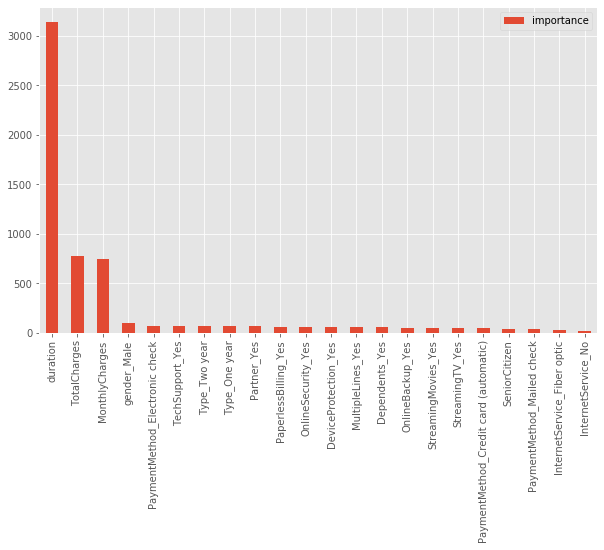

In [75]:
# Построение диаграммы значимости переменных в модели с оптимальными гиперпараметрами
plot_feature_importance(model=best_model, features_train=X_upsample, target_train=y_upsample)

- *наиболее значимые переменные*: продолжительность срока договора, совокупные выплаты, ежемесячные выплаты
- *наименее значимы переменные*: способ подключения интернета (телефонная линия, либо оптоволоконный кабель), тип оплаты по почте, является ли индивид пенсионером

In [76]:
# Определим функцию, которая выводит результирующие метрики выбранной модели
def print_final_metrics(model, features_test, target_test):
    '''
    model - выбранная модель с оптимальными гиперпараметрами
    features_test - матрица характеристи тестового множества
    target_test - вектор целевого признака тестового множества
    
    Вывод метрики ROC-AUC, точности, классификационного отчета
    '''
    # По выбранной модели определим прогнозные значения на основе тестового множества
    predictions = model.predict(features_test)
    # Вычисление метрики ROC-AUC по выбранной модели
    roc_auc = roc_auc_score(target_test, predictions)
    # Вычисление точности по выбранной модели
    accuracy = accuracy_score(target_test, predictions)
    cls_report = classification_report(target_test, predictions)
    print('-'*53)
    print('Метрика ROC-AUC: {:.3f}'.format(roc_auc))
    print('-'*53)
    print('Точность: {:.3f}'.format(accuracy))
    print('-'*53)
    print('Классификационный отчет: \n{}'.format(cls_report))

In [77]:
# Вывод результирующих метрик
# для модели LightGBMClassifier(learning_rate=0.1, n_estimators=190) на расширенной выборке
print_final_metrics(model=best_model, features_test=X_test, target_test=y_test)

-----------------------------------------------------
Метрика ROC-AUC: 0.950
-----------------------------------------------------
Точность: 0.964
-----------------------------------------------------
Классификационный отчет: 
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       479
           1       0.97      0.98      0.98      1282

    accuracy                           0.96      1761
   macro avg       0.96      0.95      0.95      1761
weighted avg       0.96      0.96      0.96      1761



- *f1_score*: среднее гармоническое полноты и точности варьирует от `0.93` (для "отрицательного" класса) до `0.98` ("положительного" класса). 

### Выводы

- способы балансирования целевого признака: (1) `upsample`: в три раза увеличили долю наименьшего класса в векторе целевого признака: долю недействующих пользователей, (2) `downsample`: отобрали 35 процентов преобладающего класса в векторе целевого признака.
- *наиболее значимые переменные*: продолжительность срока договора, совокупные выплаты, ежемесячные выплаты
- *наименее значимы переменные*: способ подключения интернета (телефонная линия, либо оптоволоконный кабель), тип оплаты по почте, является ли индивид пенсионером
- наибольшие средние величины метрики `ROC-AUC` по кросс-валидации: `LightGBM` на расширенной выборке составляет `0.910`
- наибольшие средние величины точности по кросс-валидации: `LightGBM` на расширенной выборке составляет `0.910`
- гиперпараметры выбранной наилучшей модели `LightGBMCLassifier` на расширенной выборке: шаг обучения составляет `0.1`, количество деревьев составляет `190`.
- **результирующие метрики выбранной модели:** `ROC-AUC` составляет `0.950`, точность составляет `0.964`, `f1_score` среднее гармоническое полноты и точности варьирует от `0.93` (для "отрицательного" класса) до `0.98` (для "положительного" класса).

- **итоговая модель** $-$ `LightGBMClassifier` со следующими гиперпараметрами: количество деревьев `n_estimators` составляет `190`, шаг обучения `learning_rate` равен `0.1`, генератор псевдослучайных чисел `random_state` равен `42`. Модель обучена на расширенной выборочной совокупности (`upsampling`).
- **качество итоговой модели**: метрика `ROC-AUC` составляет `0.950`, метрика `accuracy` составляет `0.964`, метрика `f1_score` составляет `0.93` для отрицательного класса и `0.98` для положительного класса.